In [2]:
# make sure the notebook reloads the module each time we modify it
%load_ext autoreload
%autoreload 2

# make sure the displays are nice
%matplotlib inline
#figsize(12,8)

In [34]:
from src.arms import *
from Experiments import *
from src.stochastic_bandit import *
from src.multiplayers import *
import matplotlib.pyplot as plt

In [145]:

bandit=BernoulliMAB([.5,.6,.7],m=2)
players=[PlayerSelfish(nb_arms=3, nb_players=2,policy=KlUCBPolicy(bandit.arms)) for i in range(2)]
max_time=100
selections, collisions, chairs, sensing_infos=multiplayer_env(bandit, players, max_time)

cumulative_centralised_regret(bandit,selections)

array([0.1, 0.2, 0.3, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7, 0.6, 0.6, 0.5, 0.5,
       0.4, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.9, 0.9, 1.1, 1.3, 1.3, 1.3,
       1.3, 1.4, 1.5, 1.4, 1.4, 1.5, 1.7, 1.9, 2.1, 2.3, 2.4, 2.6, 2.9,
       3.1, 3.1, 3.1, 3.1, 3.1, 3. , 2.9, 2.8, 2.7, 2.6, 2.5, 2.4, 2.3,
       2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.5, 2.4, 2.4,
       2.4, 2.4, 2.4, 2.3, 2.2, 2.1, 2. , 2. , 1.9, 1.9, 1.8, 1.7, 1.6,
       1.5, 1.4, 1.3, 1.4, 1.5, 1.5, 1.5, 1.4, 1.3])

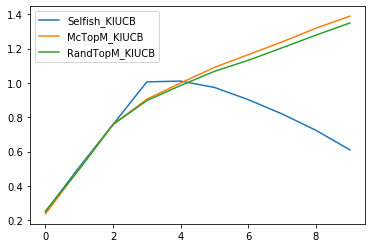

In [150]:
nb_arms=3
nb_players=2
n_random_arm=5000
max_time=10
strategies=[PlayerSelfish,PlayerMcTop,PlayerRandTop]
policy=KlUCBPolicy
run_experiments(n_random_arm,nb_arms,strategies,policy,nb_players,max_time)